#### Import libraries

In [1]:
import os 
import sys
sys.path.append('..')
import glob

import numpy as np
import xarray as xr

from tqdm import tqdm

import torch
import captum.attr as attr
import itertools

import wandb
import random

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature


#Models
from models.swin_fir.swin_fir import SwinFIR_sidechannel

#Data
from dataset_utils.LightningDataModules import Era2CerraDataModule

/home/cide/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cide/.local/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


#### Single forward function for Captum

In [2]:
def single_output_forward(channel):
    def forward(x_main, x_side):
        yhat = model((x_main, x_side))[0][:, channel]
        yhat_avg = yhat.mean(dim=[1, 2])
        return yhat_avg.unsqueeze(0)
    return forward

#### Configuration

In [3]:
# Model Path
model_path = "/home/cide/Documents/5.-Downscaling/downscaling-SwinFSD/AirPollution_Run/Full_Images_200_epochs_Charbonier/output/models/example-epoch=181-val_loss=0.1960.ckpt"
data_path = "/home/cide/Documents/5.-Downscaling/downscaling-SwinFSD/data"

model_class = SwinFIR_sidechannel
constant_channels = True
num_workers = 8
crop_size_era = 35
crop_size_cerra = 140
batch_size = 1
standarized = True
transform = False

num_batches = 300

xai_channel = 0
in_channels = [0, 1, 2, 3, 4, 5]
out_channels = [0]

area = 'deterministic'
test_years = (2022, 2022)

#geo_eval = False
#deterministic_eval = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

separate_dataset = True

In [4]:
run = wandb.init(project='airpollution-downscaling-swin-fir', entity = "marcos-martinez-roig-universitat-de-val-ncia", group="era2cerra", job_type="xai", name="xai_Charbonnier")

wandb: Currently logged in as: marcos-martinez-roig (marcos-martinez-roig-universitat-de-val-ncia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
model = model_class.load_from_checkpoint(model_path)
model = model.to(device)
model.eval()

/home/cide/anaconda3/envs/downscaling/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.2, which is newer than your current Lightning version: v2.5.1.post0


Dataset metrics provided. Using provided values.
Dataset metrics provided. Using provided values.


SwinFIR_sidechannel(
  (loss_function): CharbonnierLoss()
  (conv_first): Conv2d(6, 220, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sidechannel_conv_first): Conv2d(2, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((220,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (downsample_sidechannel): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(20, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (sidechannel_patch_embed): PatchEmbed(
    (norm): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
  )
  (sidechannel_patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=240, input_resolution=(35, 35), depth=5
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=240, input_resolution=(35, 35)

In [6]:
channel_names = np.array(model.hparams.channel_names)
out_channel_names = channel_names[out_channels]
in_channel_names = channel_names[in_channels]
in_channel_names[-1] = 't2m' #Error during training
names_side = ['pop', 'z']
all_channel_names = list(in_channel_names) + names_side
channel_names = channel_names.squeeze()
print(f"Out channels: {out_channel_names}, In channels: {in_channel_names}")

Out channels: ['pm2p5'], In channels: ['pm2p5' 'blh' 'u10' 'v10' 'd2m' 't2m']


In [7]:
wandb.config['data_path'] = data_path
wandb.config['model_path'] = model_path
wandb.config['model'] = model_class.__name__
wandb.config['constant_channels'] = constant_channels
wandb.config['crop_size_era'] = crop_size_era
wandb.config['crop_size_cerra'] = crop_size_cerra
wandb.config['batch_size'] = batch_size
wandb.config['test_years'] = test_years
wandb.config['channel_names'] = channel_names.tolist()
wandb.config['in_channels'] = in_channels
wandb.config['xai_channel'] = xai_channel #out_channel_names[xai_channel]

#### Load Data

In [8]:
data_module = Era2CerraDataModule(data_path, batch_size=batch_size, standarized=standarized, transform=transform,
                                  crop_size_era=crop_size_era, crop_size_cerra=crop_size_cerra, cropping=area, 
                                  spatial_split_test=test_years, 
                                  return_era_original=False, 
                                  return_offset=True, 
                                  downscaling_factor=1, #model.hparams.upscale, 
                                  constant_channels=constant_channels, 
                                  num_workers=num_workers, 
                                  out_channels=model.hparams.out_channels, 
                                  in_channels=in_channels, 
                                  use_separate_dataset=separate_dataset)


data_module.setup('test')

dataloader = data_module.test_dataloader()

Loading Era2Cerra DataModule 

Loaded Mean/Std from file
Loaded Mean/Std from file
Using ERA5 and CERRA dataset with separate u10/v10
Returning the following channels as LR-input: [0, 1, 2, 3, 4, 5]
Number of Files 1
Loaded Mean/Std from file
Loaded Mean/Std from file
torch.Size([2, 420, 700])
Loaded constant data from file


#### Create tensors to save results

In [9]:
attributions_main = np.zeros((len(in_channels), model.hparams.full_height_cerra//model.hparams.upscale, model.hparams.full_width_cerra//model.hparams.upscale))
input_main = np.zeros((len(in_channels), model.hparams.full_height_cerra//model.hparams.upscale, model.hparams.full_width_cerra//model.hparams.upscale))
attributions_side = np.zeros((2, model.hparams.full_height_cerra, model.hparams.full_width_cerra))
input_side = np.zeros((2, model.hparams.full_height_cerra, model.hparams.full_width_cerra))

In [10]:
xAI_technique = 'IntGra' #Saliency, InpxGra, IntGra, GuiBack, GradCAM GuiGradCAM...    FA, FP

In [11]:
attributions_main_list = []
input_main_list = []
attributions_side_list = []
input_side_list = []

exception_count = 0
count = 0
batch_count = 0
# Get the first batch
for batch in tqdm(dataloader):
    batch_count += 1

    if xAI_technique == 'Saliency':
        ig = attr.Saliency(single_output_forward(xai_channel))
    elif xAI_technique == 'InpxGra':
        ig = attr.InputXGradient(single_output_forward(xai_channel))
    elif xAI_technique == 'IntGra':
        ig = attr.IntegratedGradients(single_output_forward(xai_channel))
    elif xAI_technique == 'GuiBack':
        raise ValueError('Not Implemented')
        ig = attr.GuidedBackprop(model)
    elif xAI_technique == 'GradCAM':
        raise ValueError('Not Implemented')
        ig = attr.LayerGradCam(model, model.conv_after_body)
    elif xAI_technique == 'GuiGradCAM':
        raise ValueError('Not Implemented')
    
        
    data = batch
    input = data[0]

    input_main = input[0].to(device)
    input_side = input[1].to(device)

    target_data = data[1][0].to(device)
    target = target_data[:, xai_channel].mean(dim=(1, 2)).to(device)

    try:

        if xAI_technique == 'Saliency':
            attributions = ig.attribute((input_main, input_side))
            delta = 0
        elif xAI_technique == 'InpxGra':
            attributions = ig.attribute((input_main, input_side))
            delta = 0
        elif xAI_technique == 'IntGra':
            attributions, delta = ig.attribute((input_main, input_side), target=target.long(), return_convergence_delta=True, n_steps=5)
        elif xAI_technique == 'GuiBack':
            raise ValueError('Not Implemented')
            attributions = ig.attribute((input_main, input_side), target = target.long())
            delta = 0
        elif xAI_technique == 'GradCAM':
            raise ValueError('Not Implemented')
            attributions = ig.attribute((input_main, input_side), target=target.long())
            delta = 0
        elif xAI_technique == 'GuiGradCAM':
            raise ValueError('Not Implemented')
            
        attributions_main = abs(attributions[0]).detach().cpu().numpy().mean(axis=(0)).squeeze()
        input_main = input_main.detach().cpu().numpy().mean(axis=(0)).squeeze()
        attributions_side = abs(attributions[1]).detach().cpu().numpy().mean(axis=(0)).squeeze()
        input_side = input_side.detach().cpu().numpy().mean(axis=(0)).squeeze()

        attributions_main_list.append(attributions_main)
        input_main_list.append(input_main)
        attributions_side_list.append(attributions_side)
        input_side_list.append(input_side)
        
    except Exception as e:
        print(f"[ERROR in batch {batch_count}] {type(e).__name__}: {e}")    
        exception_count += 1
        continue

    if batch_count == num_batches:
        break

100%|██████████| 131/131 [1:54:00<00:00, 52.21s/it]


In [12]:
print(f"An exception occured in {exception_count} of {count} iterations")

An exception occured in 0 of 0 iterations


In [13]:
del attributions, delta, attributions_main, attributions_side, data, input, input_main, input_side,  target_data, target

In [14]:
attributions_main_total = np.stack(attributions_main_list)
input_main_total = np.stack(input_main_list)
attributions_side_total = np.stack(attributions_side_list)
input_side_total = np.stack(input_side_list)

In [15]:
del attributions_main_list, input_main_list, attributions_side_list, input_side_list

#### Path to save

In [16]:
attribution_path = os.path.join(os.getcwd(), 'attribution_results', xAI_technique, 'test')
if not os.path.exists(attribution_path):
    os.makedirs(attribution_path)

In [17]:
# Save the attributions
np.save(os.path.join(attribution_path, "attribution_main"), attributions_main_total)
np.save(os.path.join(attribution_path, "input_main"), input_main_total)
np.save(os.path.join(attribution_path, "attribution_side"), attributions_side_total)
np.save(os.path.join(attribution_path, "input_side"), input_side_total)

#### Take Coords for the maps

In [18]:
# Paths to read coords, name vars and save data
cerra_data_dir = os.path.join(os.getcwd(), 'data', 'CERRA', 'preprocessed_separate')
cerra_files = glob.glob(os.path.join(cerra_data_dir, 'test') + "/**/*.nc", recursive=True)
ds_cerra = xr.open_dataset(os.path.join(cerra_data_dir, cerra_files[0]))
ds_aux_file = xr.open_dataset(os.path.join(cerra_data_dir, 'aux_variables_standarized.nc'))

era_data_dir = os.path.join(os.getcwd(), 'data', 'ERA5', 'preprocessed_separate')
era_files = glob.glob(os.path.join(era_data_dir, 'test') + "/**/*.nc", recursive=True)
ds_era = xr.open_dataset(os.path.join(era_data_dir, era_files[0]))

In [19]:
max_time = num_batches * batch_size
coords_era = {
    'time': ds_era.coords['time'][:max_time],
    'latitude': ds_era.coords['latitude'][:-1],
    'longitude': ds_era.coords['longitude'][:-1]
}

coords_cerra = {
    'time': ds_cerra.coords['time'][:max_time],
    'latitude': ds_cerra.coords['latitude'],
    'longitude': ds_cerra.coords['longitude']
}

#coords_aux = {dim: ds_aux_file.coords[dim] for dim in ['latitude', 'longitude']}

In [20]:
era_var_names = list(ds_era.data_vars) 
aux_var_names = list(ds_aux_file.data_vars) 

print(f"ERA5 variables: {era_var_names}")
print(f"Auxiliary variables: {aux_var_names}")

ERA5 variables: ['pm2p5', 'blh', 'u10', 'v10', 'd2m', 't2m']
Auxiliary variables: ['pop', 'z']


In [21]:
ds_attribution_main = xr.Dataset()
ds_input_main = xr.Dataset()

for i, var_name in enumerate(era_var_names):
    data_attr_var = attributions_main_total[:, i, :, :]
    data_input_var = input_main_total[:, i, :, :] 

    ds_attribution_main[var_name] = (['time', 'latitude', 'longitude'], data_attr_var)
    ds_input_main[var_name] = (['time', 'latitude', 'longitude'], data_input_var)

ds_attribution_main = ds_attribution_main.assign_coords(coords_era)
ds_input_main = ds_input_main.assign_coords(coords_era)
#ds_attribution_main.to_netcdf(os.path.join(attribution_path, f'attribution_main.nc'))
#ds_input_main.to_netcdf(os.path.join(attribution_path, f'input_main.nc'))

In [22]:
del era_var_names, data_attr_var, data_input_var, attributions_main_total, input_main_total, coords_era

In [23]:
ds_attribution_side = xr.Dataset()
ds_input_side = xr.Dataset()

for i, var_name in enumerate(aux_var_names):
    data_attr_var = attributions_side_total[:, i, :, :] 
    data_input_var = input_side_total[:, i, :, :]

    ds_attribution_side[var_name] = (['time', 'latitude', 'longitude'], data_attr_var)
    ds_input_side[var_name] = (['time', 'latitude', 'longitude'], data_input_var)
ds_attribution_side = ds_attribution_side.assign_coords(coords_cerra)
ds_input_side = ds_input_side.assign_coords(coords_cerra)
#ds_attribution_side.to_netcdf(os.path.join(attribution_path, f'attribution_aux.nc'))
#ds_attribution_side.to_netcdf(os.path.join(attribution_path, f'input_aux.nc'))

In [24]:
del aux_var_names, data_attr_var, data_input_var, attributions_side_total, input_side_total, coords_cerra 

#### Choose a timestep to see

In [25]:
timestep = 0

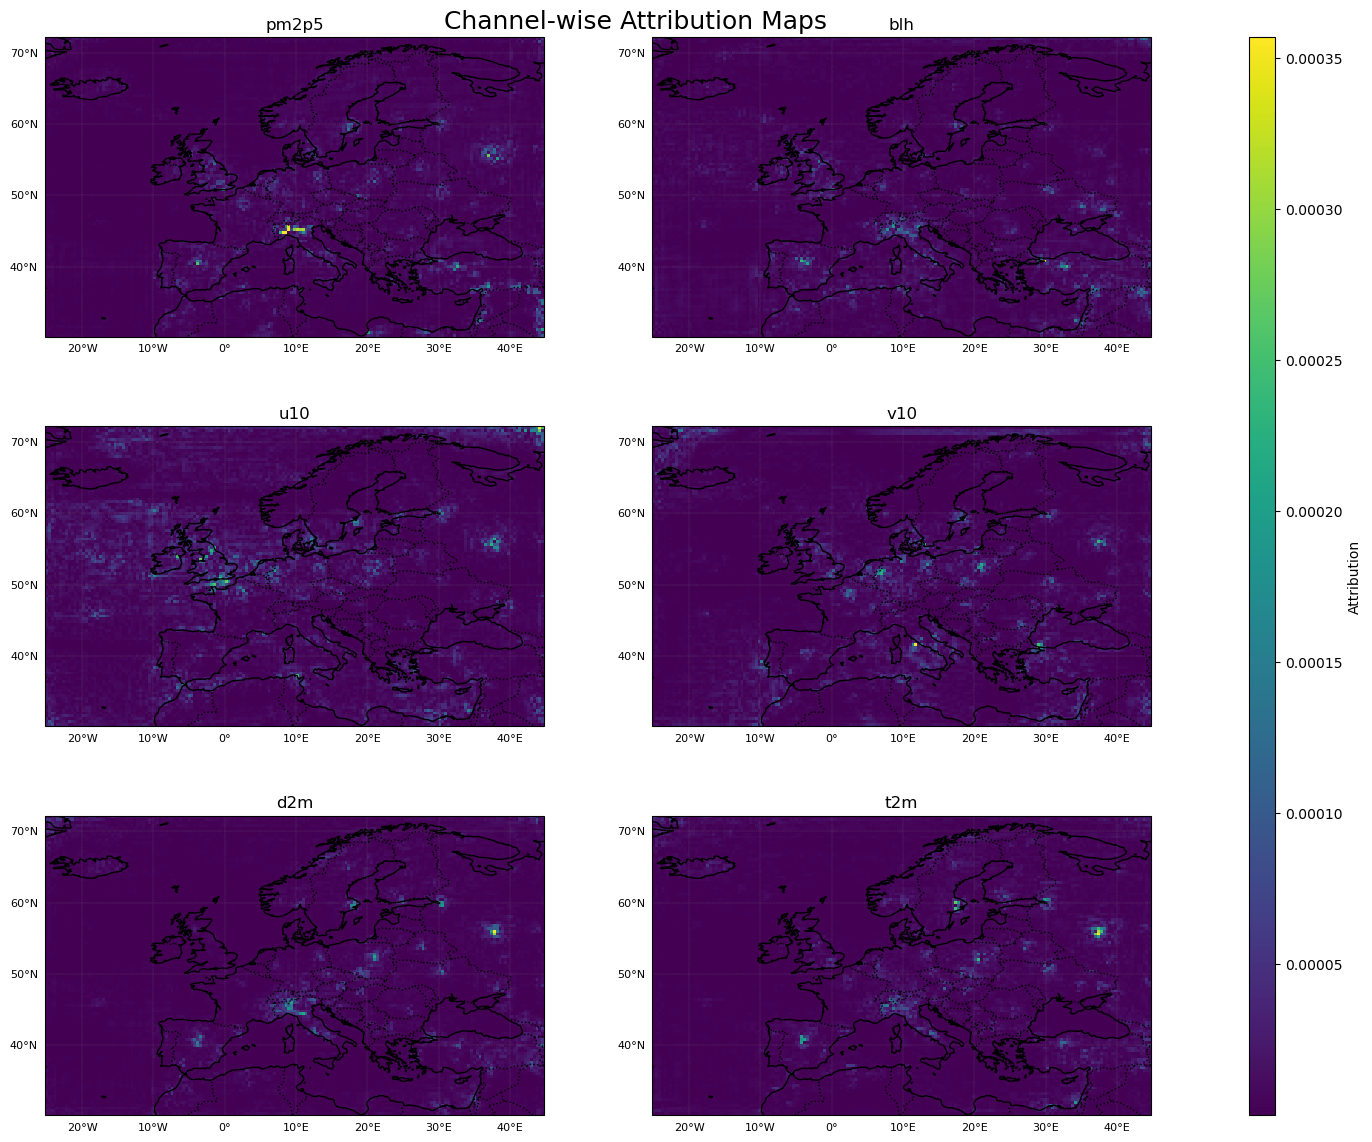

In [26]:
data = ds_attribution_main.isel(time=timestep)

# Crear figura con espacio para la colorbar (3 filas x 3 columnas)
fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 0.05], wspace=0.25, hspace=0.3)

axs = []
ims = []

# Dibujar los 6 subplots en 3x2
for i, var in enumerate(in_channel_names):
    row = i // 2
    col = i % 2
    ax = plt.subplot(gs[row, col], projection=ccrs.PlateCarree())
    da = data[var]

    im = ax.pcolormesh(da['longitude'], da['latitude'], da, transform=ccrs.PlateCarree(), cmap='viridis')

    ax.set_title(var)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    axs.append(ax)
    ims.append(im)

# Barra de color en la última columna (tercera)
cax = plt.subplot(gs[:, 2])
cbar = fig.colorbar(ims[0], cax=cax)
cbar.set_label("Attribution")

# Título general y guardar
plt.suptitle("Channel-wise Attribution Maps", fontsize=18, y=0.9)
plt.savefig(os.path.join(attribution_path, "attribution_main.png"), dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"Attribution_main": wandb.Image(os.path.join(attribution_path, "attribution_main.png"))})

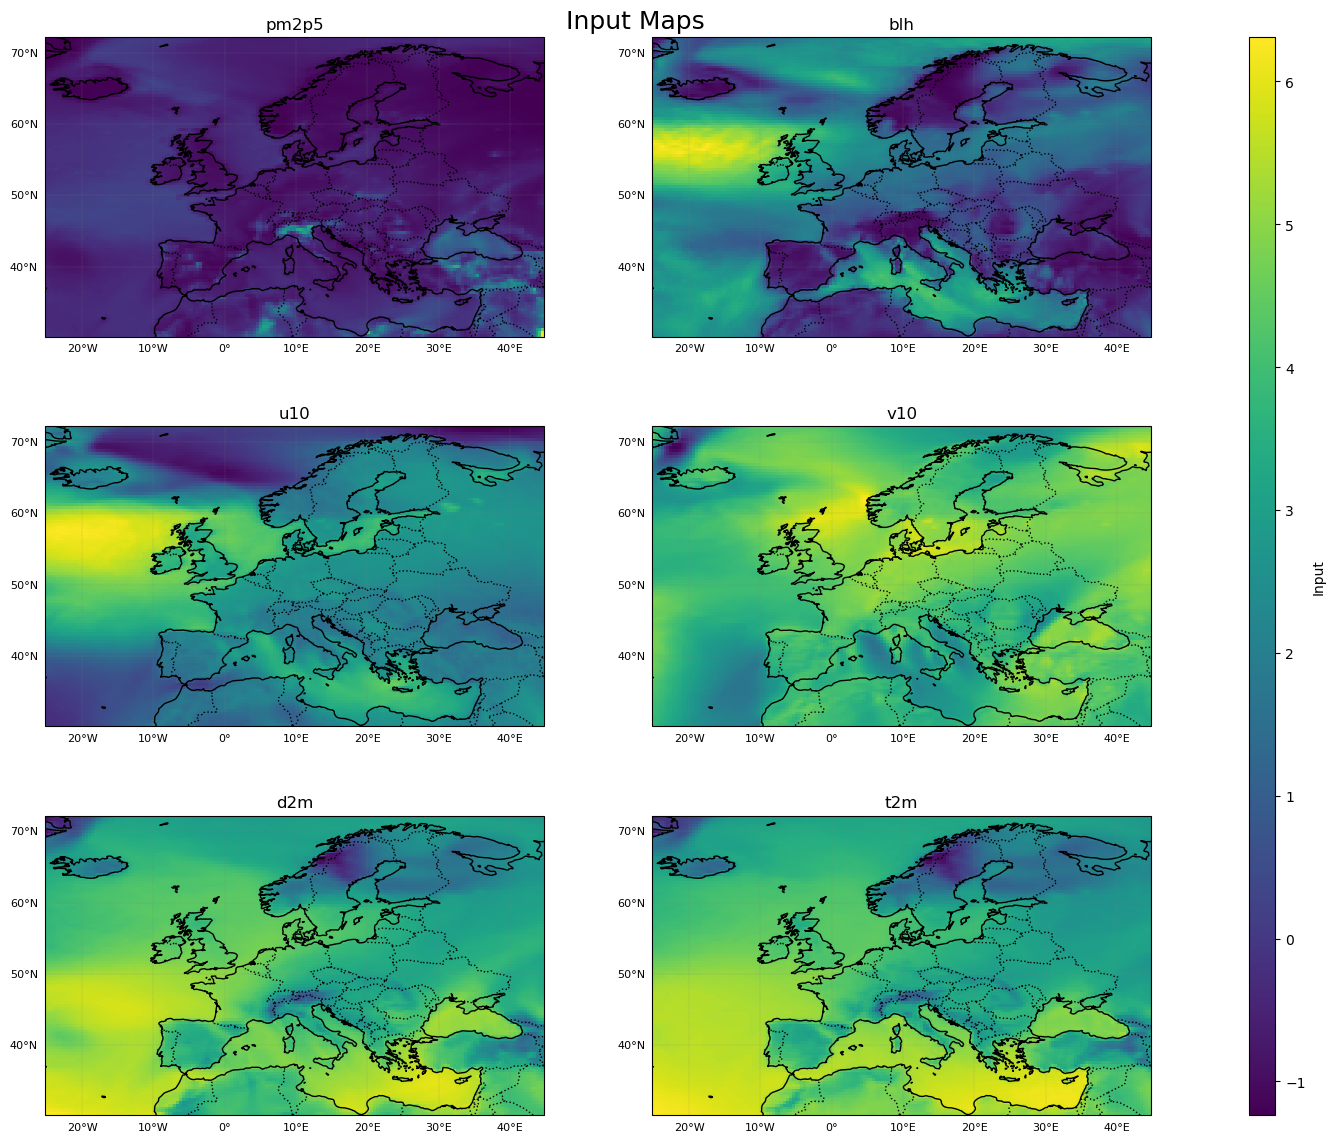

In [27]:
data = ds_input_main.isel(time=timestep)

# Crear figura con espacio para la colorbar (3 filas x 3 columnas)
fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 0.05], wspace=0.25, hspace=0.3)

axs = []
ims = []

# Dibujar los 6 subplots en 3x2
for i, var in enumerate(in_channel_names):
    row = i // 2
    col = i % 2
    ax = plt.subplot(gs[row, col], projection=ccrs.PlateCarree())
    da = data[var]

    im = ax.pcolormesh(da['longitude'], da['latitude'], da, transform=ccrs.PlateCarree(), cmap='viridis')

    ax.set_title(var)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    axs.append(ax)
    ims.append(im)

# Barra de color en la última columna (tercera)
cax = plt.subplot(gs[:, 2])
cbar = fig.colorbar(ims[0], cax=cax)
cbar.set_label("Input")

# Título general y guardar
plt.suptitle("Input Maps", fontsize=18, y=0.9)
plt.savefig(os.path.join(attribution_path, "input_main.png"), dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"input_main": wandb.Image(os.path.join(attribution_path, "input_main.png"))})

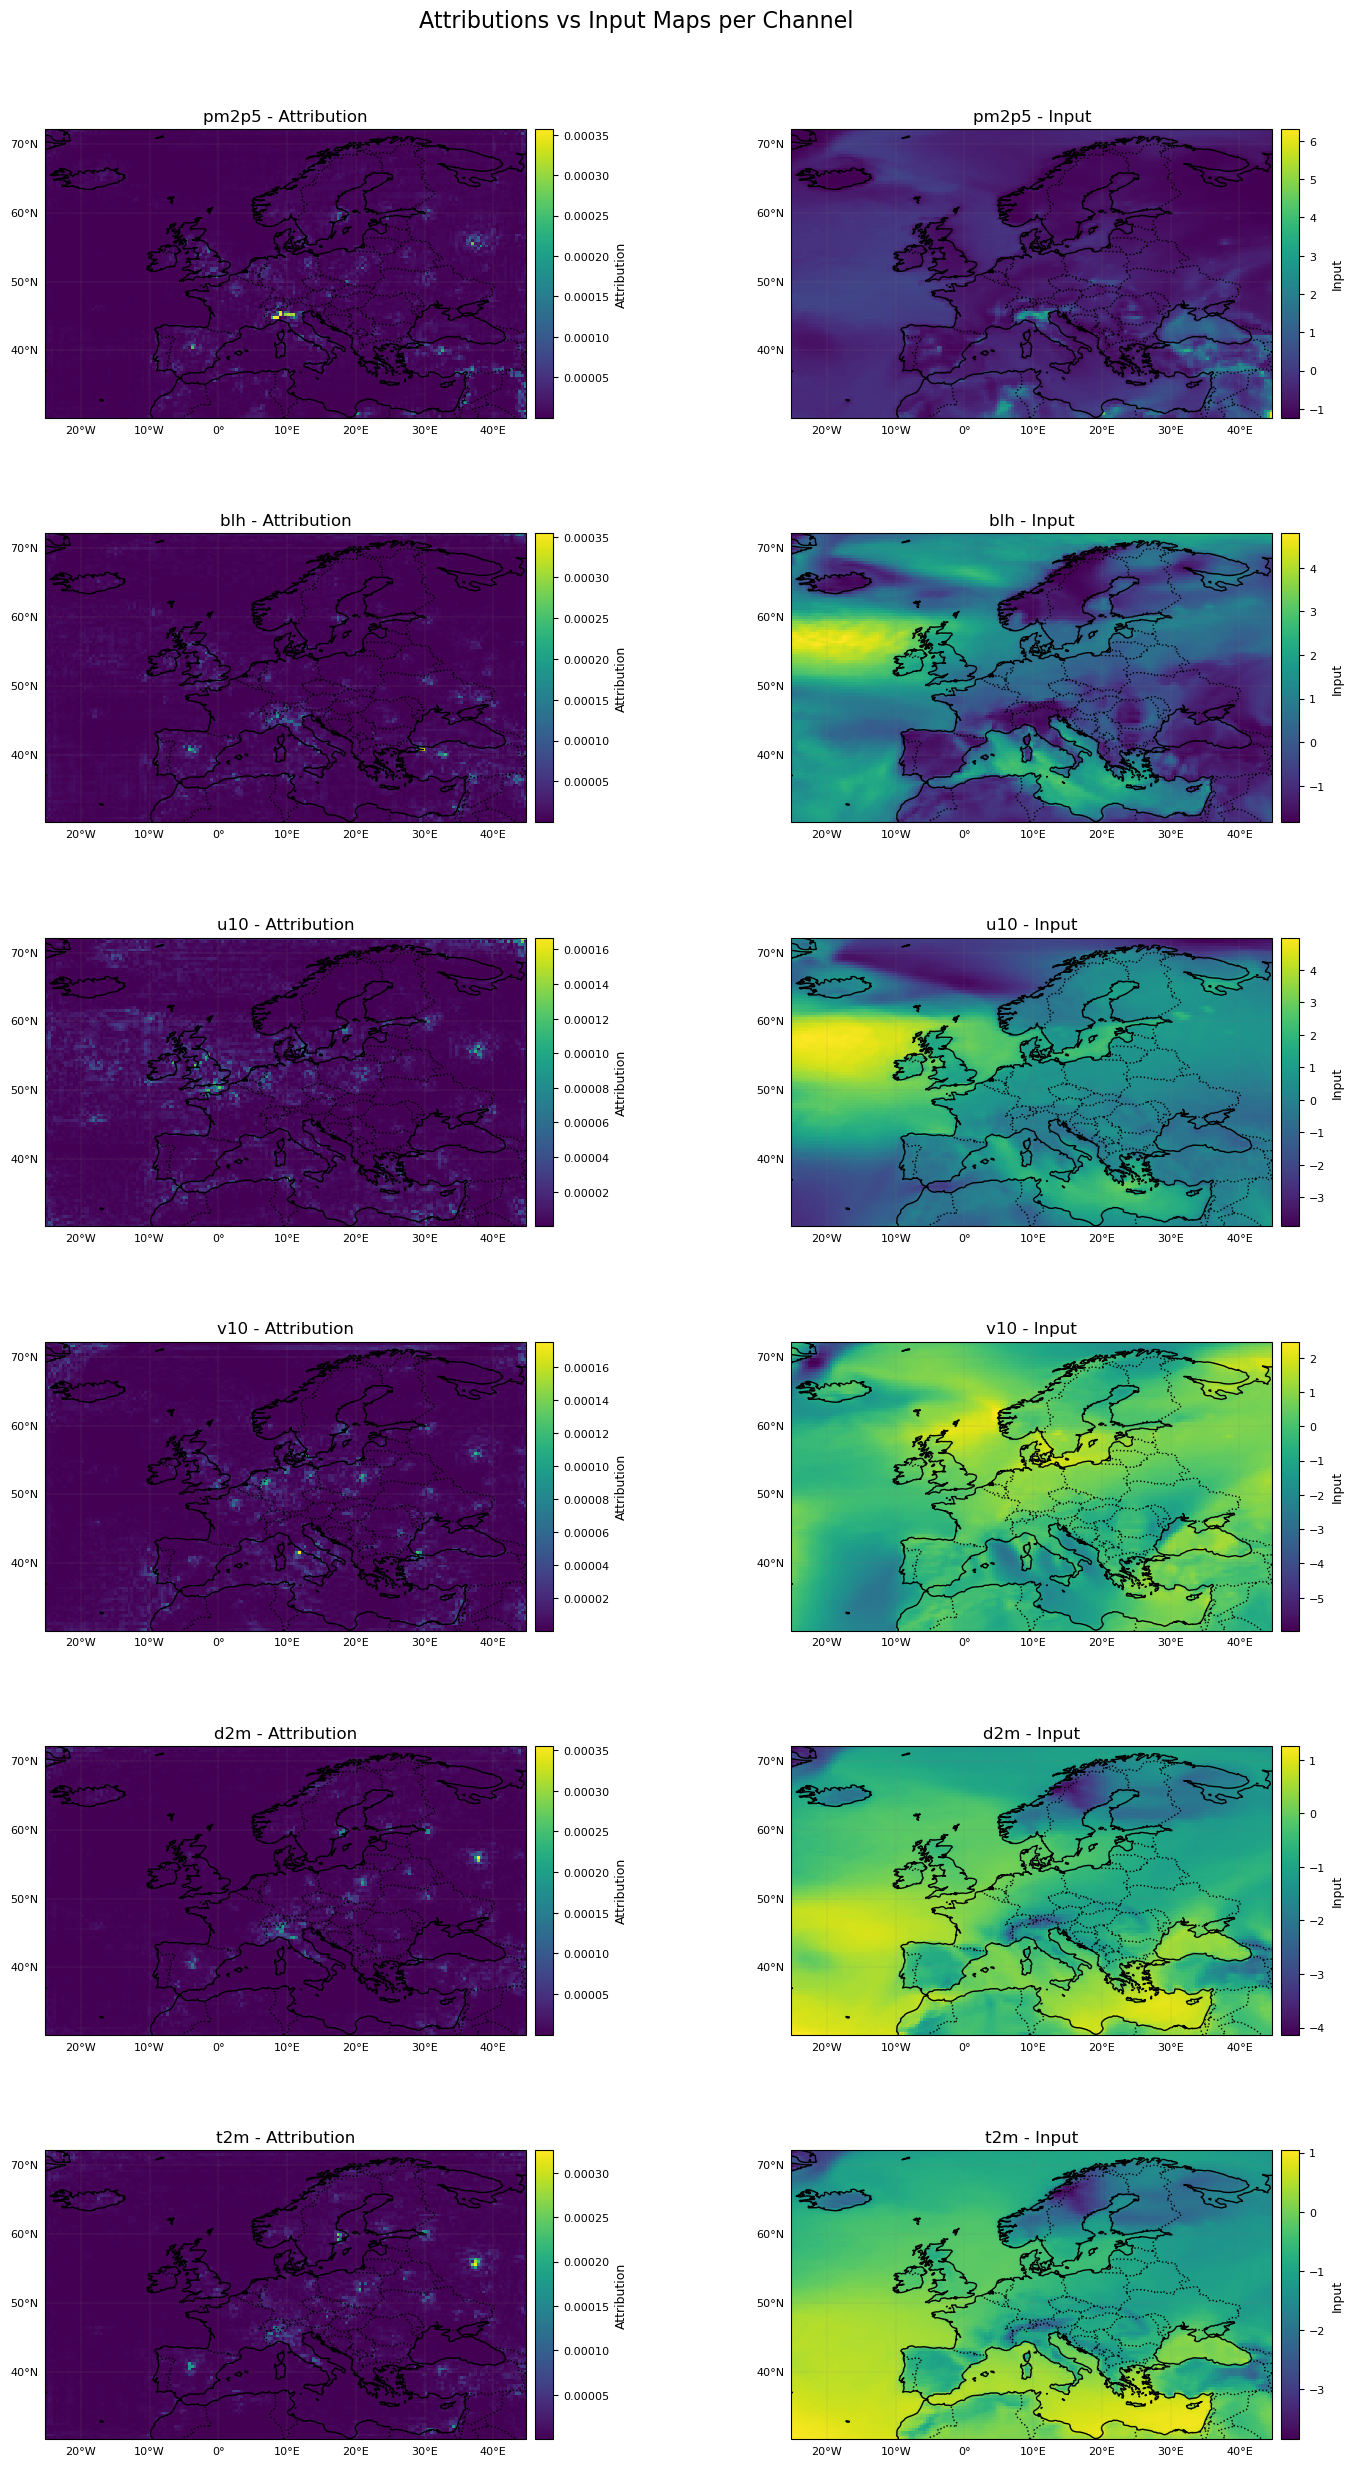

In [28]:
channels = len(in_channel_names)
fig = plt.figure(figsize=(18, 5 * channels))
gs = gridspec.GridSpec(nrows=channels, ncols=2, width_ratios=[1, 1], wspace=0.15, hspace=0.4)

for i, var in enumerate(in_channel_names):
    # --- Attribution ---
    ax_attr = plt.subplot(gs[i, 0], projection=ccrs.PlateCarree())
    da_attr = ds_attribution_main[var].isel(time=timestep)
    im_attr = ax_attr.pcolormesh(
        da_attr['longitude'], da_attr['latitude'], da_attr,
        transform=ccrs.PlateCarree(), cmap='viridis'
    )
    ax_attr.set_title(f"{var} - Attribution", fontsize=12)
    ax_attr.coastlines()
    ax_attr.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax_attr.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # Colorbar Attribution - manual
    pos_attr = ax_attr.get_position()
    cax_attr = fig.add_axes([pos_attr.x1 + 0.005, pos_attr.y0, 0.01, pos_attr.height])
    cb_attr = fig.colorbar(im_attr, cax=cax_attr)
    cb_attr.ax.tick_params(labelsize=8)
    cb_attr.set_label("Attribution", fontsize=9)

    # --- Input ---
    ax_input = plt.subplot(gs[i, 1], projection=ccrs.PlateCarree())
    da_input = ds_input_main[var].isel(time=timestep)
    im_input = ax_input.pcolormesh(
        da_input['longitude'], da_input['latitude'], da_input,
        transform=ccrs.PlateCarree(), cmap='viridis'
    )
    ax_input.set_title(f"{var} - Input", fontsize=12)
    ax_input.coastlines()
    ax_input.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax_input.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # Colorbar Input - manual
    pos_input = ax_input.get_position()
    cax_input = fig.add_axes([pos_input.x1 + 0.005, pos_input.y0, 0.01, pos_input.height])
    cb_input = fig.colorbar(im_input, cax=cax_input)
    cb_input.ax.tick_params(labelsize=8)
    cb_input.set_label("Input", fontsize=9)

# Título general
plt.suptitle("Attributions vs Input Maps per Channel", fontsize=16, y=0.92)
plt.savefig(os.path.join(attribution_path, "comparison_main_maps.png"), dpi=300, bbox_inches='tight')
plt.show()

# Log a wandb
#wandb.log({"Comparison_main_maps": wandb.Image(os.path.join(attribution_path, "comparison_main_maps.png"))})

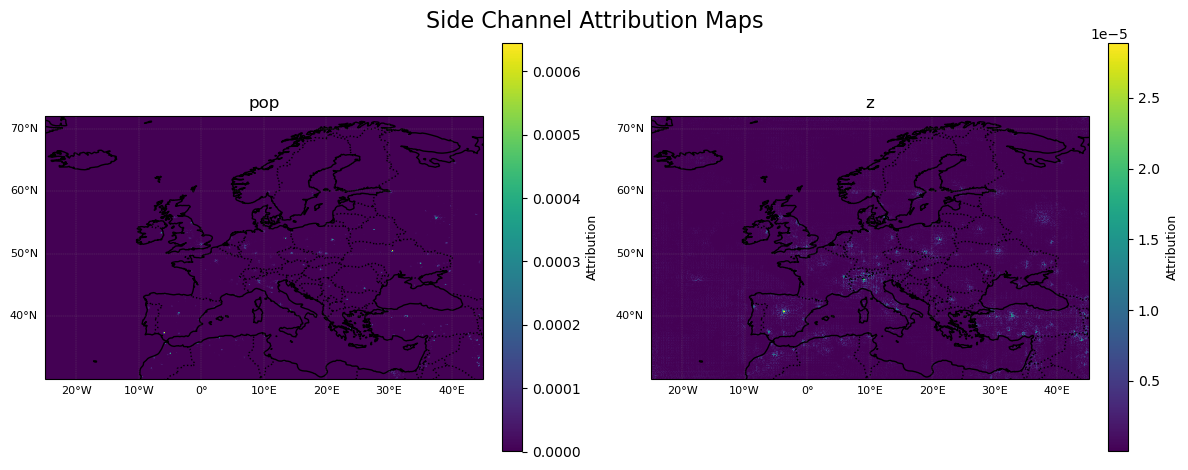

In [29]:
# Crear figura
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5),
                        subplot_kw={'projection': ccrs.PlateCarree()})

for i, name in enumerate(names_side):
    da = ds_attribution_side[name].isel(time=timestep)  # DataArray 2D

    im = axs[i].pcolormesh(
        da['longitude'], da['latitude'], da,
        transform=ccrs.PlateCarree(), cmap='viridis'
    )

    axs[i].set_title(name)
    axs[i].coastlines()
    axs[i].add_feature(cfeature.BORDERS, linestyle=':')
    gl = axs[i].gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # Barra de color individual
    cbar = fig.colorbar(im, ax=axs[i], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label("Attribution", fontsize=9)

# Título y guardar
plt.suptitle("Side Channel Attribution Maps", fontsize=16, y=0.93)
plt.tight_layout()
plt.savefig(os.path.join(attribution_path, "attribution_side.png"), dpi=300, bbox_inches='tight')
plt.show()

# Log a wandb
wandb.log({"Attribution_side": wandb.Image(os.path.join(attribution_path, "attribution_side.png"))})

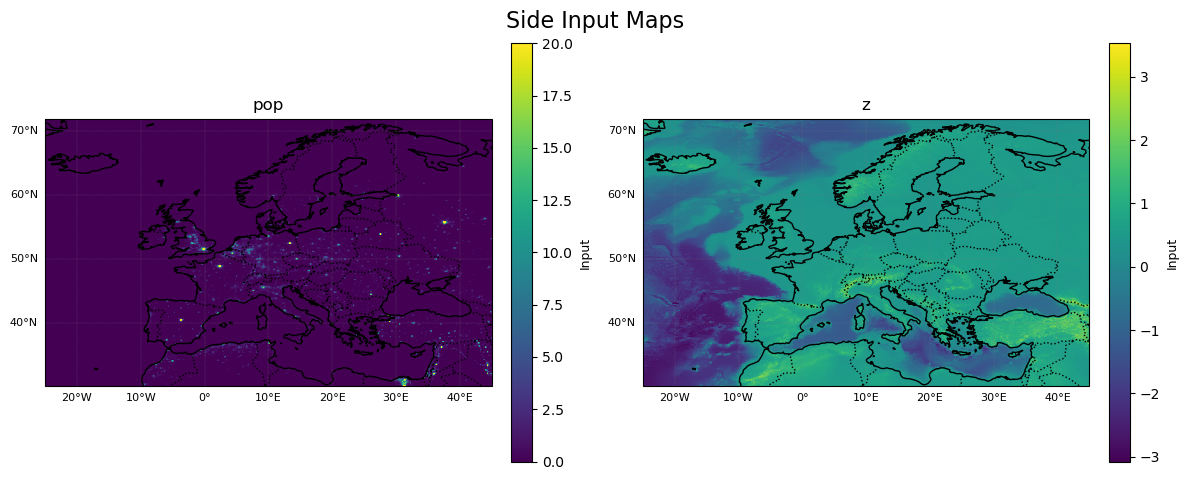

In [30]:
# Crear figura
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5),
                        subplot_kw={'projection': ccrs.PlateCarree()})

for i, name in enumerate(names_side):
    da = ds_input_side[name].isel(time=timestep)  # DataArray 2D

    if i==0:
        im = axs[i].pcolormesh(da['longitude'], da['latitude'], da, transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=20)
    else:
        im = axs[i].pcolormesh(da['longitude'], da['latitude'], da, transform=ccrs.PlateCarree(), cmap='viridis')

    axs[i].set_title(name)
    axs[i].coastlines()
    axs[i].add_feature(cfeature.BORDERS, linestyle=':')
    gl = axs[i].gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # Barra de color individual
    cbar = fig.colorbar(im, ax=axs[i], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label("Input", fontsize=9)

# Título y guardar
plt.suptitle("Side Input Maps", fontsize=16, y=0.95)
plt.tight_layout()
plt.savefig(os.path.join(attribution_path, "input_side.png"), dpi=300, bbox_inches='tight')
plt.show()

# Log a wandb
wandb.log({"Input_side": wandb.Image(os.path.join(attribution_path, "input_side.png"))})

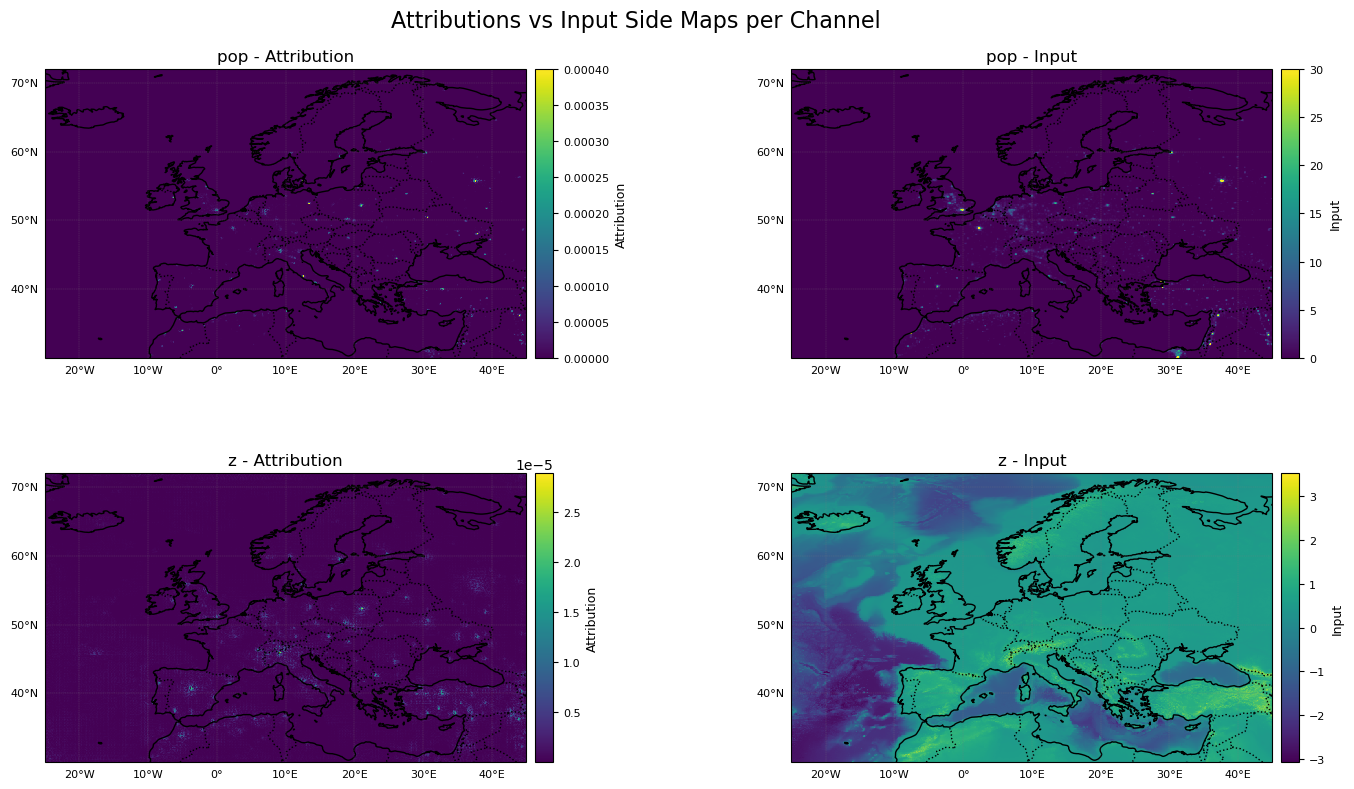

In [31]:
channels = len(in_channel_names)
fig = plt.figure(figsize=(18, 5 * channels))
gs = gridspec.GridSpec(nrows=channels, ncols=2, width_ratios=[1, 1], wspace=0.15, hspace=0.4)

for i, var in enumerate(names_side):
    # --- Attribution ---
    ax_attr = plt.subplot(gs[i, 0], projection=ccrs.PlateCarree())
    da_attr = ds_attribution_side[var].isel(time=timestep)
    if i == 0:
        im_attr = ax_attr.pcolormesh(da_attr['longitude'], da_attr['latitude'], da_attr, transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=0.0004)
    else:
        im_attr = ax_attr.pcolormesh(da_attr['longitude'], da_attr['latitude'], da_attr, transform=ccrs.PlateCarree(), cmap='viridis')
    ax_attr.set_title(f"{var} - Attribution", fontsize=12)
    ax_attr.coastlines()
    ax_attr.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax_attr.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # Colorbar Attribution - manual
    pos_attr = ax_attr.get_position()
    cax_attr = fig.add_axes([pos_attr.x1 + 0.005, pos_attr.y0, 0.01, pos_attr.height])
    cb_attr = fig.colorbar(im_attr, cax=cax_attr)
    cb_attr.ax.tick_params(labelsize=8)
    cb_attr.set_label("Attribution", fontsize=9)

    # --- Input ---
    ax_input = plt.subplot(gs[i, 1], projection=ccrs.PlateCarree())
    da_input = ds_input_side[var].isel(time=timestep)
    if i == 0:
        im_input = ax_input.pcolormesh(da_input['longitude'], da_input['latitude'], da_input, transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=30)
    else:
        im_input = ax_input.pcolormesh(da_input['longitude'], da_input['latitude'], da_input, transform=ccrs.PlateCarree(), cmap='viridis')
    ax_input.set_title(f"{var} - Input", fontsize=12)
    ax_input.coastlines()
    ax_input.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax_input.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # Colorbar Input - manual
    pos_input = ax_input.get_position()
    cax_input = fig.add_axes([pos_input.x1 + 0.005, pos_input.y0, 0.01, pos_input.height])
    cb_input = fig.colorbar(im_input, cax=cax_input)
    cb_input.ax.tick_params(labelsize=8)
    cb_input.set_label("Input", fontsize=9)

# Título general
plt.suptitle("Attributions vs Input Side Maps per Channel", fontsize=16, y=0.9)
plt.savefig(os.path.join(attribution_path, "comparison_side_maps.png"), dpi=300, bbox_inches='tight')
plt.show()

# Log a wandb
wandb.log({"Comparison_side_maps": wandb.Image(os.path.join(attribution_path, "comparison_side_maps.png"))})

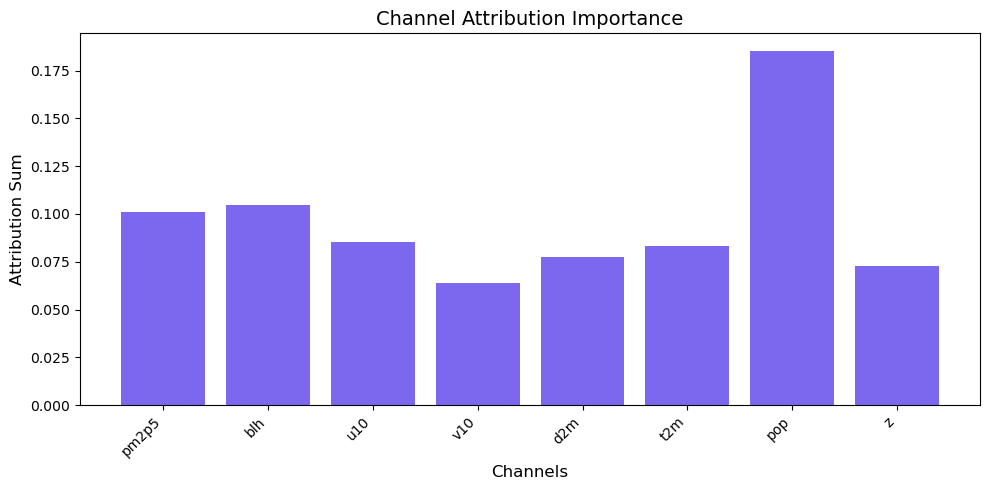

Error: You must call wandb.init() before wandb.log()

In [47]:
relevance_main = []
in_channel_names = list(ds_attribution_main.data_vars)

for var in in_channel_names:
    da = ds_attribution_main[var].isel(time=timestep)
    rel = np.abs(da.values).sum()
    relevance_main.append(rel)

relevance_side = []
names_side = list(ds_attribution_side.data_vars)

for var in names_side:
    da = ds_attribution_side[var].isel(time=timestep)
    rel = np.abs(da.values).sum()
    relevance_side.append(rel)

all_relevances = relevance_main + relevance_side

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(all_channel_names, all_relevances, color='mediumslateblue')

ax.set_title("Channel Attribution Importance", fontsize=14)
ax.set_xlabel("Channels", fontsize=12)
ax.set_ylabel("Attribution Sum", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig(os.path.join(attribution_path, "integrated_importance_interp.png"), dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"Integrated_importance_interp": wandb.Image(os.path.join(attribution_path, "integrated_importance_interp.png"))})

#### Spatial interpolation of aux variables to be comparable with main

In [32]:
ds_attribution_side_interp = ds_attribution_side.interp_like(ds_input_main, method='nearest')

In [33]:
ds_attribution_side_interp

<xarray.Dataset>
Dimensions:    (time: 131, latitude: 105, longitude: 175)
Coordinates:
    level      float32 0.0
  * time       (time) datetime64[ns] 2024-12-21 2023-01-06 ... 2023-10-28
  * latitude   (latitude) float64 72.0 71.6 71.2 70.8 ... 31.6 31.2 30.8 30.4
  * longitude  (longitude) float64 -25.0 -24.6 -24.2 -23.8 ... 43.8 44.2 44.6
Data variables:
    pop        (time, latitude, longitude) float64 nan nan ... 1.736e-07
    z          (time, latitude, longitude) float64 nan nan ... 8.38e-07

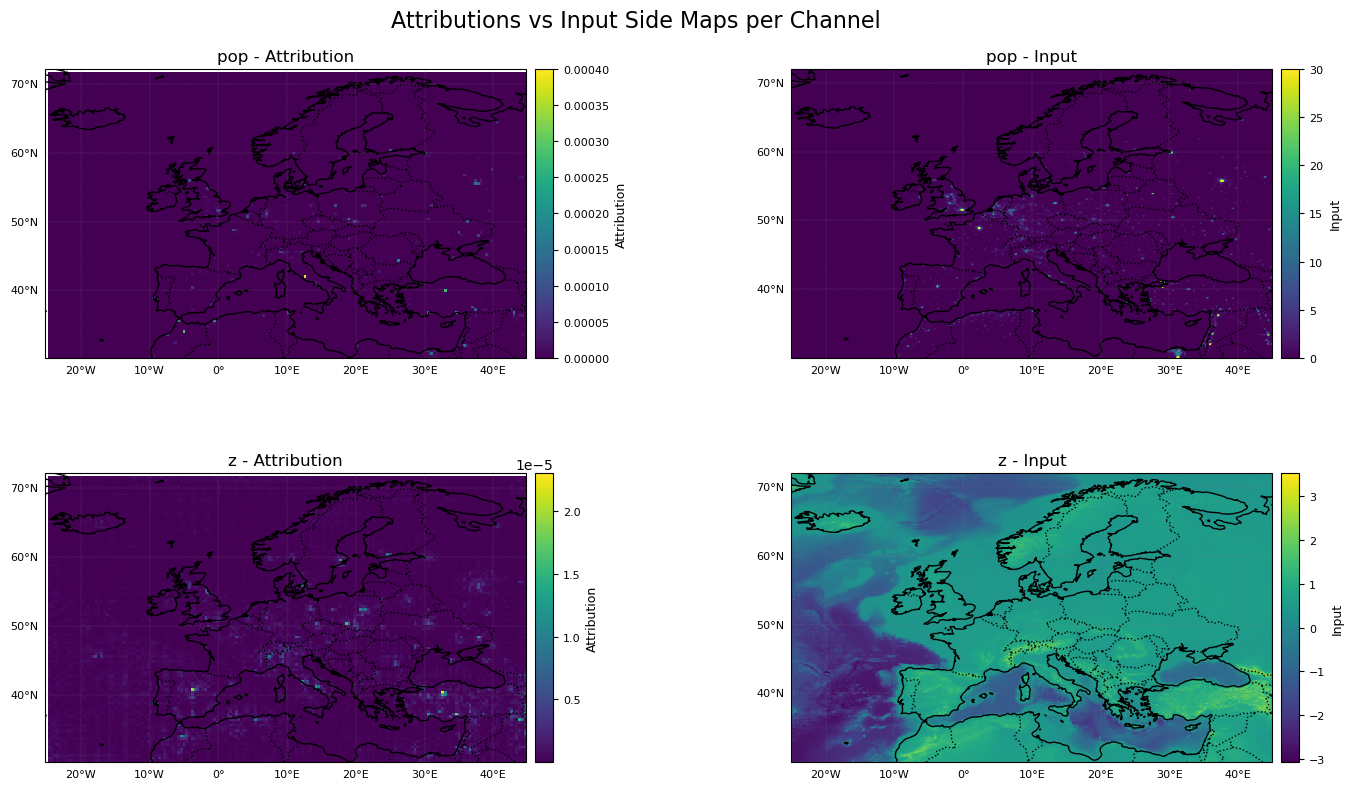

In [34]:
channels = len(in_channel_names)
fig = plt.figure(figsize=(18, 5 * channels))
gs = gridspec.GridSpec(nrows=channels, ncols=2, width_ratios=[1, 1], wspace=0.15, hspace=0.4)

for i, var in enumerate(names_side):
    # --- Attribution ---
    ax_attr = plt.subplot(gs[i, 0], projection=ccrs.PlateCarree())
    da_attr = ds_attribution_side_interp[var].isel(time=timestep)
    if i == 0:
        im_attr = ax_attr.pcolormesh(da_attr['longitude'], da_attr['latitude'], da_attr, transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=0.0004)
    else:
        im_attr = ax_attr.pcolormesh(da_attr['longitude'], da_attr['latitude'], da_attr, transform=ccrs.PlateCarree(), cmap='viridis')
    ax_attr.set_title(f"{var} - Attribution", fontsize=12)
    ax_attr.coastlines()
    ax_attr.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax_attr.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # Colorbar Attribution - manual
    pos_attr = ax_attr.get_position()
    cax_attr = fig.add_axes([pos_attr.x1 + 0.005, pos_attr.y0, 0.01, pos_attr.height])
    cb_attr = fig.colorbar(im_attr, cax=cax_attr)
    cb_attr.ax.tick_params(labelsize=8)
    cb_attr.set_label("Attribution", fontsize=9)

    # --- Input ---
    ax_input = plt.subplot(gs[i, 1], projection=ccrs.PlateCarree())
    da_input = ds_input_side[var].isel(time=timestep)
    if i == 0:
        im_input = ax_input.pcolormesh(da_input['longitude'], da_input['latitude'], da_input, transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=30)
    else:
        im_input = ax_input.pcolormesh(da_input['longitude'], da_input['latitude'], da_input, transform=ccrs.PlateCarree(), cmap='viridis')
    ax_input.set_title(f"{var} - Input", fontsize=12)
    ax_input.coastlines()
    ax_input.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax_input.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # Colorbar Input - manual
    pos_input = ax_input.get_position()
    cax_input = fig.add_axes([pos_input.x1 + 0.005, pos_input.y0, 0.01, pos_input.height])
    cb_input = fig.colorbar(im_input, cax=cax_input)
    cb_input.ax.tick_params(labelsize=8)
    cb_input.set_label("Input", fontsize=9)

# Título general
plt.suptitle("Attributions vs Input Side Maps per Channel", fontsize=16, y=0.9)
plt.savefig(os.path.join(attribution_path, "comparison_side_maps.png"), dpi=300, bbox_inches='tight')
plt.show()

# Log a wandb
wandb.log({"Comparison_side_maps": wandb.Image(os.path.join(attribution_path, "comparison_side_maps.png"))})

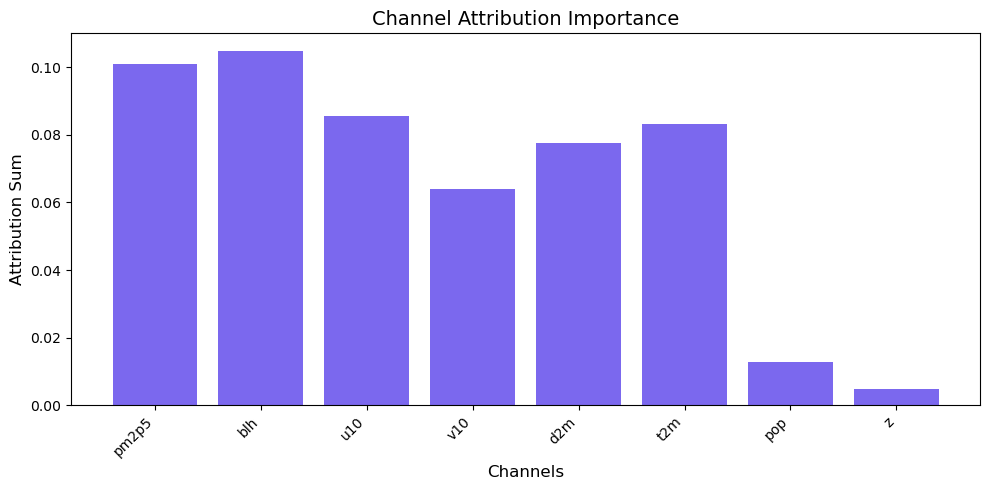

In [35]:
relevance_main = []
in_channel_names = list(ds_attribution_main.data_vars)

for var in in_channel_names:
    da = ds_attribution_main[var].isel(time=timestep)
    rel = np.abs(da.values).sum()
    relevance_main.append(rel)

relevance_side = []
names_side = list(ds_attribution_side.data_vars)

for var in names_side:
    da = ds_attribution_side_interp[var].isel(time=timestep).fillna(0)
    rel = np.abs(da.values).sum()
    relevance_side.append(rel)

all_relevances = relevance_main + relevance_side

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(all_channel_names, all_relevances, color='mediumslateblue')

ax.set_title("Channel Attribution Importance", fontsize=14)
ax.set_xlabel("Channels", fontsize=12)
ax.set_ylabel("Attribution Sum", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig(os.path.join(attribution_path, "integrated_importance.png"), dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"Integrated_importance": wandb.Image(os.path.join(attribution_path, "integrated_importance.png"))})

#### Average over time

In [37]:
attribution_main_avg_time = ds_attribution_main.sum(dim='time')
attribution_side_avg_time = ds_attribution_side.sum(dim='time')

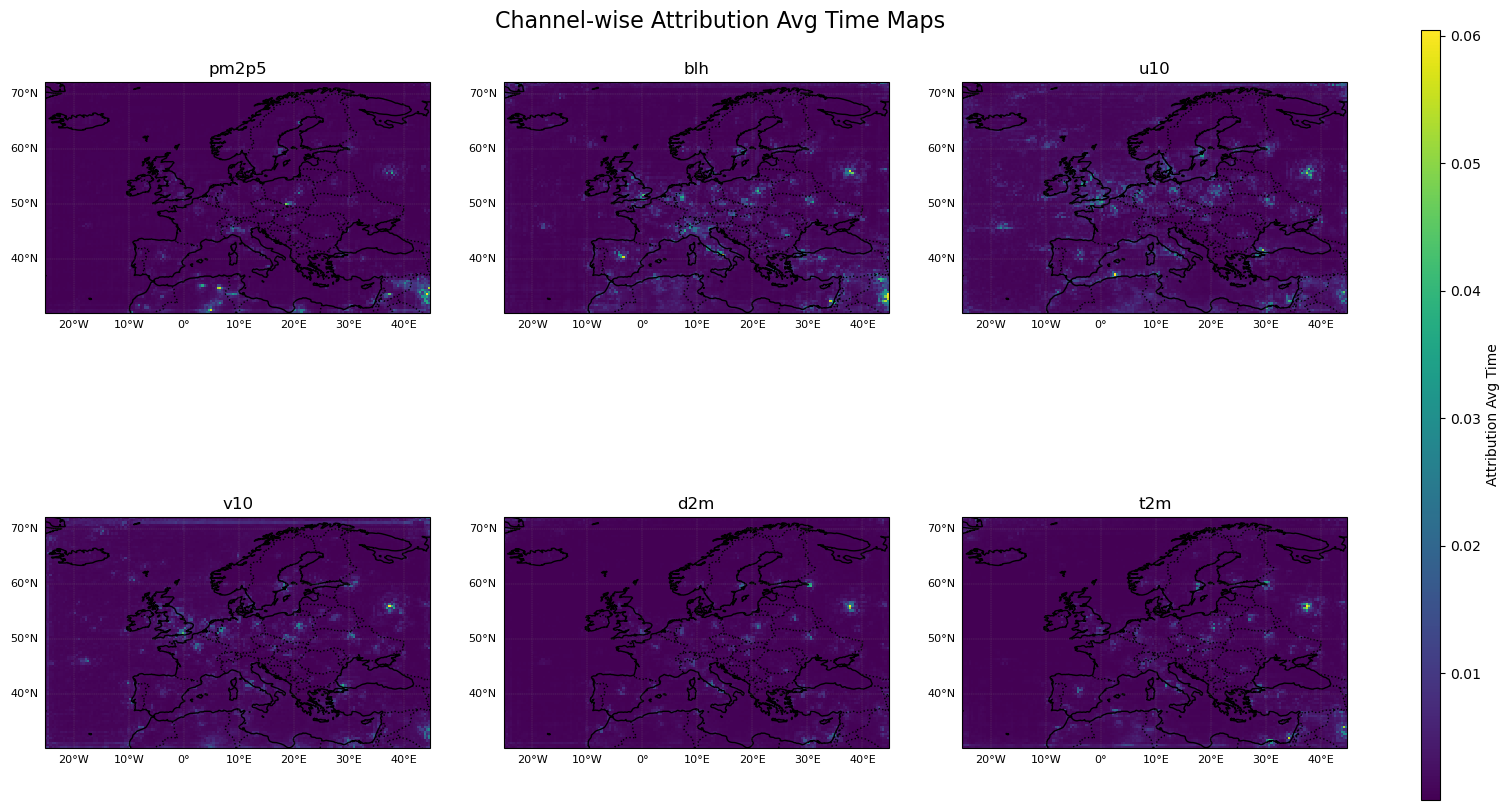

In [38]:
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.25, hspace=0.3)

axs = []
ims = []

for i, var in enumerate(in_channel_names):
    row = i // 3
    col = i % 3
    ax = plt.subplot(gs[row, col], projection=ccrs.PlateCarree())
    da = attribution_main_avg_time[var]  # xarray.DataArray (lat, lon)

    im = ax.pcolormesh(
        da['longitude'], da['latitude'], da,
        transform=ccrs.PlateCarree(), cmap='viridis', #vmin=0, vmax=0.005
    )

    ax.set_title(var)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    axs.append(ax)
    ims.append(im)

# Barra de color común
cax = plt.subplot(gs[:, 3])
cbar = fig.colorbar(ims[0], cax=cax)
cbar.set_label("Attribution Avg Time")

# Título global y guardar
plt.suptitle("Channel-wise Attribution Avg Time Maps", fontsize=16, y=0.9)
plt.savefig(os.path.join(attribution_path, "attribution_avg_time_main.png"), dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"Attribution_avg_time_main": wandb.Image(os.path.join(attribution_path, "attribution_avg_time_main.png"))})


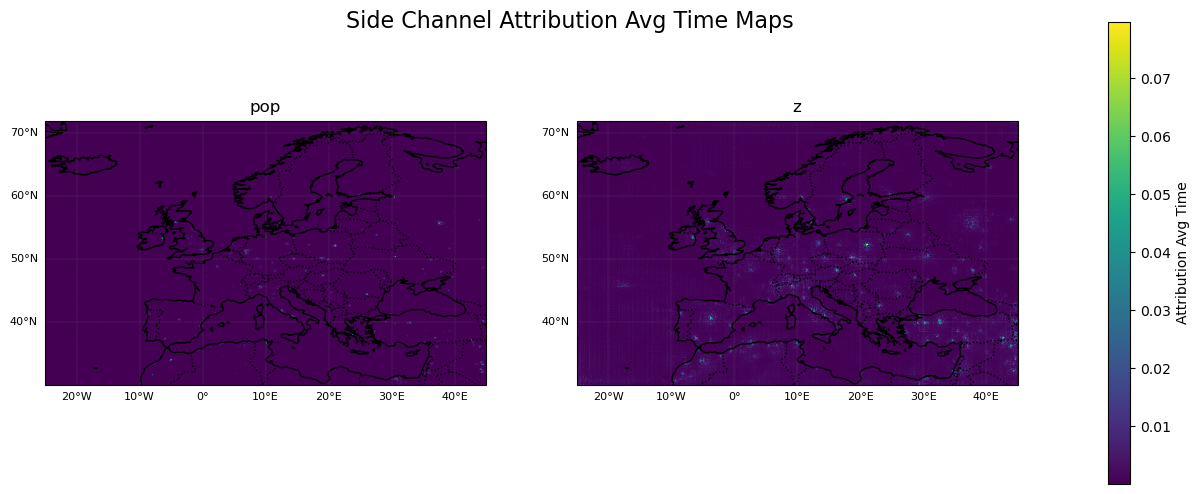

In [39]:
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)

ims = []

for i, var in enumerate(names_side):
    ax = plt.subplot(gs[0, i], projection=ccrs.PlateCarree())
    da = attribution_side_avg_time[var]

    im = ax.pcolormesh(
        da['longitude'], da['latitude'], da,
        transform=ccrs.PlateCarree(), cmap='viridis'
    )
    ax.set_title(var)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    ims.append(im)

# Barra de color global a la derecha
cax = plt.subplot(gs[0, 2])
cbar = fig.colorbar(ims[0], cax=cax)
cbar.set_label("Attribution Avg Time")

plt.suptitle("Side Channel Attribution Avg Time Maps", fontsize=16, y=0.9)
plt.savefig(os.path.join(attribution_path, "attribution_avg_time_side.png"), dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"Attribution_avg_time_side": wandb.Image(os.path.join(attribution_path, "attribution_avg_time_side.png"))})


#### Average over space

In [40]:
relevance_main_time = ds_attribution_main.sum(dim=['latitude', 'longitude'])
relevance_side_time = ds_attribution_side.sum(dim=['latitude', 'longitude'])
relevance_side_time_interp = ds_attribution_side_interp.sum(dim=['latitude', 'longitude'])

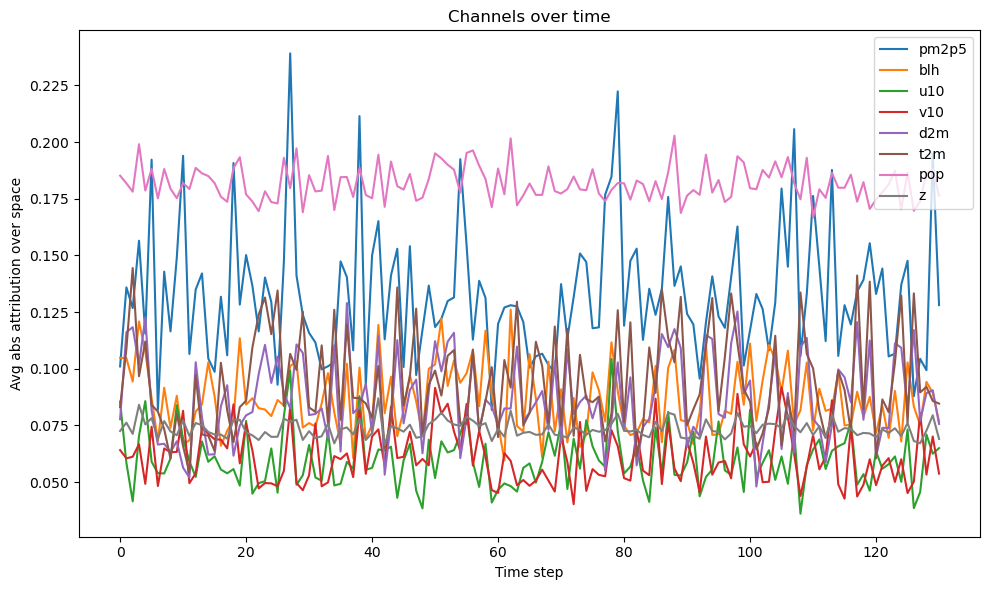

<Figure size 640x480 with 0 Axes>

In [41]:
# Combinar todos los arrays (cada uno de shape (time,))
main_vals = relevance_main_time.to_array().values  # shape: (main_channels, time)
side_vals = relevance_side_time.to_array().values  # shape: (side_channels, time)

# Concatenar en el eje de canales (fila = canal, col = timestep)
attribution_avg_space_combined = np.concatenate([main_vals, side_vals], axis=0)  # shape: (C, T)

# Transponer para que sea (T, C) como en tu código original
attribution_avg_space_combined = attribution_avg_space_combined.T

# Graficar
fig, ax = plt.subplots(figsize=(10, 6))
l, c = attribution_avg_space_combined.shape

for ch in range(c):
    ax.plot(range(l), attribution_avg_space_combined[:, ch], label=all_channel_names[ch])

ax.set_title("Channels over time")
ax.set_xlabel("Time step")
ax.set_ylabel("Avg abs attribution over space")
ax.legend()
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(attribution_path, "attribution_avg_space_over_time.png"), dpi=300, bbox_inches='tight')
wandb.log({"Attribution_avg_space_over_time": wandb.Image(os.path.join(attribution_path, "attribution_avg_space_over_time.png"))})


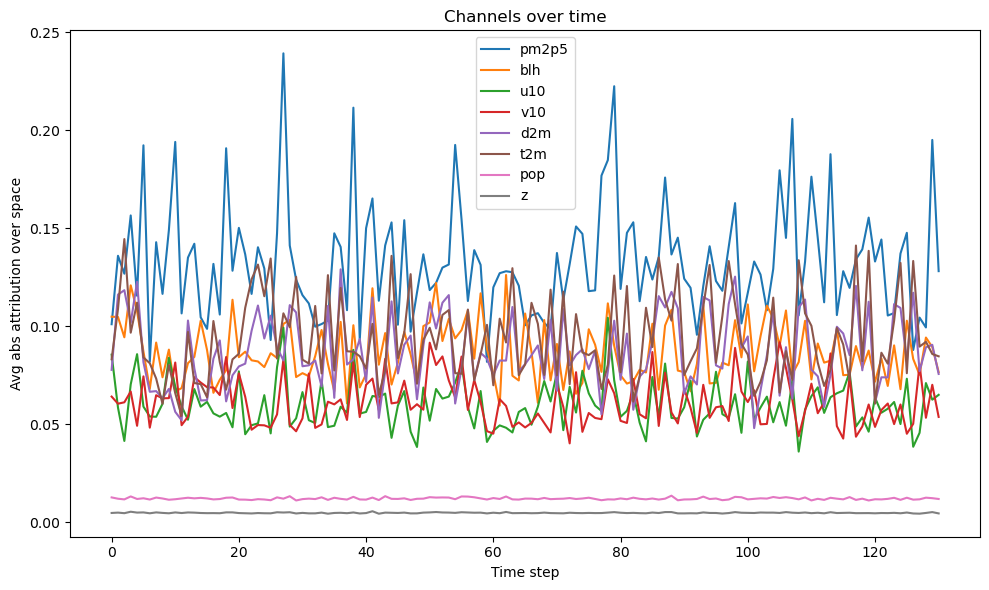

<Figure size 640x480 with 0 Axes>

In [42]:
# Combinar todos los arrays (cada uno de shape (time,))
main_vals = relevance_main_time.to_array().values  # shape: (main_channels, time)
side_vals = relevance_side_time_interp.to_array().values  # shape: (side_channels, time)

# Concatenar en el eje de canales (fila = canal, col = timestep)
attribution_avg_space_combined = np.concatenate([main_vals, side_vals], axis=0)  # shape: (C, T)

# Transponer para que sea (T, C) como en tu código original
attribution_avg_space_combined = attribution_avg_space_combined.T

# Graficar
fig, ax = plt.subplots(figsize=(10, 6))
l, c = attribution_avg_space_combined.shape

for ch in range(c):
    ax.plot(range(l), attribution_avg_space_combined[:, ch], label=all_channel_names[ch])

ax.set_title("Channels over time")
ax.set_xlabel("Time step")
ax.set_ylabel("Avg abs attribution over space")
ax.legend()
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(attribution_path, "attribution_avg_space_over_time.png"), dpi=300, bbox_inches='tight')
wandb.log({"Attribution_avg_space_over_time": wandb.Image(os.path.join(attribution_path, "attribution_avg_space_over_time.png"))})

#### Average time and space

In [43]:
relevance_main_time_space = relevance_main_time.mean(dim=['time'])
relevance_side_time_space = relevance_side_time.mean(dim=['time'])
relevance_side_time_space_intercept = relevance_side_time_interp.mean(dim=['time'])

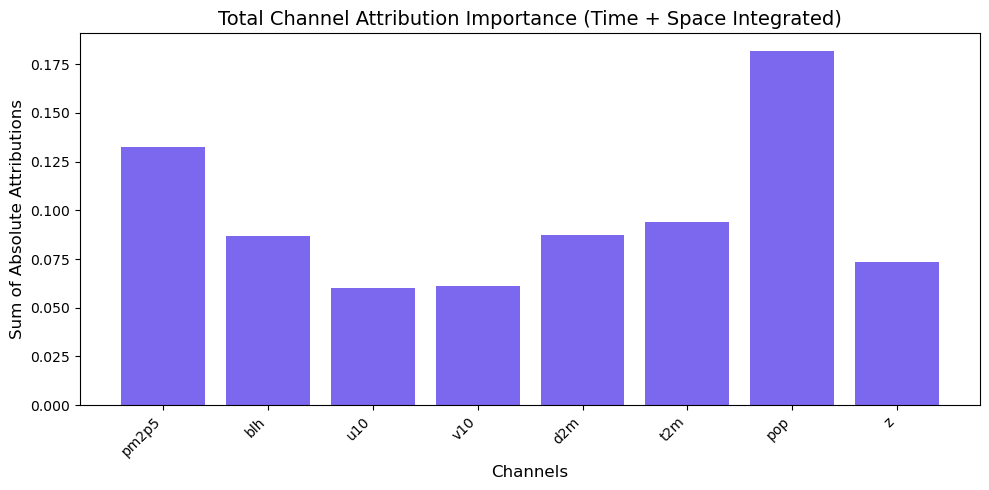

In [44]:
all_channel_names = in_channel_names + names_side

# Valores por canal (convertimos cada variable a escalar)
main_vals = [relevance_main_time_space[var].item() for var in in_channel_names]
side_vals = [relevance_side_time_space[var].item() for var in names_side]
all_relevances = main_vals + side_vals

# Crear gráfico
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(all_channel_names, all_relevances, color='mediumslateblue')

ax.set_title("Total Channel Attribution Importance (Time + Space Integrated)", fontsize=14)
ax.set_xlabel("Channels", fontsize=12)
ax.set_ylabel("Sum of Absolute Attributions", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Guardar y loguear
output_file = os.path.join(attribution_path, "integrated_importance_time_space.png")
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"Integrated_importance_time_space": wandb.Image(output_file)})

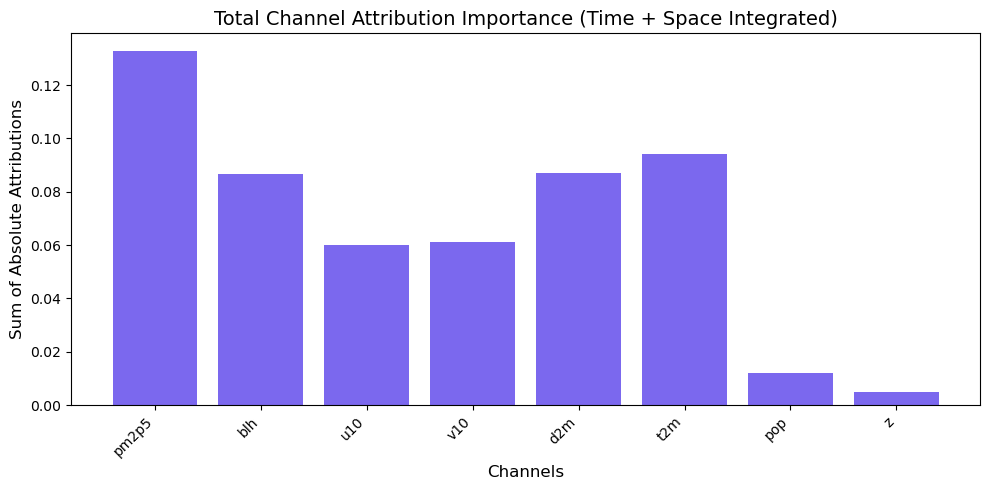

In [45]:
all_channel_names = in_channel_names + names_side

# Valores por canal (convertimos cada variable a escalar)
main_vals = [relevance_main_time_space[var].item() for var in in_channel_names]
side_vals = [relevance_side_time_space_intercept[var].item() for var in names_side]
all_relevances = main_vals + side_vals

# Crear gráfico
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(all_channel_names, all_relevances, color='mediumslateblue')

ax.set_title("Total Channel Attribution Importance (Time + Space Integrated)", fontsize=14)
ax.set_xlabel("Channels", fontsize=12)
ax.set_ylabel("Sum of Absolute Attributions", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Guardar y loguear
output_file = os.path.join(attribution_path, "integrated_importance_time_space.png")
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"Integrated_importance_time_space": wandb.Image(output_file)})

#### End wandb session

In [46]:
run.finish()